In [ ]:
pip install flask requests beautifulsoup4 pandas matplotlib seaborn nltk scikit-learn

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, precision_recall_curve, auc,
                           mean_absolute_error, accuracy_score)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


import matplotlib.font_manager as fm
import platform
plt.rcParams['font.family'] = 'Malgun Gothic'

In [88]:
#%% ==================================================
# Task 1: 환경 설정 및 데이터 로드
#%% ==================================================

print("=" * 50)
print("Task 1: 환경 설정 및 데이터 로드")
print("=" * 50)

# 데이터 로드 (경제지표 포함)
df = pd.read_csv('dart_with_economic_indicators.csv')

print(f"데이터 shape: {df.shape}")
print(f"기업 수: {df['corp_name'].nunique()}")
print(f"기간: {df['year'].min()} ~ {df['year'].max()}")

# 분기 정렬
from pandas import CategoricalDtype
qcat = CategoricalDtype(categories=['Q1','Q2','Q3','Q4'], ordered=True)
df['quarter'] = df['quarter'].astype(qcat)
df = df.sort_values(['corp_name','year','quarter']).reset_index(drop=True)

# 7개 재무지표 정의
feature_cols = ['부채비율', '자기자본비율', 'ROA', 'ROE', 
                '매출액성장률', '영업이익성장률', '순이익성장률']

# 5개 경제지표 정의
economic_cols = ['construction_bsi_actual', 'base_rate', 'housing_sale_price', 'm2_growth', 'credit_spread']

# 결측치 처리
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

for col in economic_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"사용할 재무지표 (7개): {feature_cols}")
print(f"사용할 경제지표 (5개): {economic_cols}")
print("Task 1 완료\n")


Task 1: 환경 설정 및 데이터 로드
데이터 shape: (1172, 21)
기업 수: 32
기간: 2016 ~ 2025
사용할 재무지표 (7개): ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
사용할 경제지표 (5개): ['construction_bsi_actual', 'base_rate', 'housing_sale_price', 'm2_growth', 'credit_spread']
Task 1 완료



In [89]:
#%% ==================================================
# Task 1-1: 경제지표 시프트 (t분기 → t-1분기)
#%% ==================================================

print("=" * 50)
print("Task 1-1: 경제지표 시프트")
print("=" * 50)

# 경제지표를 1분기 앞으로 시프트 (t분기 경제지표로 t분기 위험도 예측하기 위함)
# 구조: t-1분기 재무지표 + t분기 경제지표 → t분기 위험도 예측

print("시프트 전 경제지표 통계:")
for col in economic_cols:
    print(f"{col}: 평균 {df[col].mean():.2f}, 결측치 {df[col].isna().sum()}개")

# 각 기업별로 경제지표를 1분기 앞으로 시프트
for indicator in economic_cols:
    df[f'{indicator}_shifted'] = df.groupby('corp_name')[indicator].shift(-1)

print(f"\n시프트 완료:")
print("- 목적: t-1분기 재무지표 + t분기 경제지표 → t분기 위험도 예측")

# 시프트 후 사용 가능한 데이터 확인
shifted_cols = [f'{col}_shifted' for col in economic_cols]
for col in shifted_cols:
    available = df[col].notna().sum()
    total = len(df)
    print(f"- {col}: {available}/{total} ({available/total*100:.1f}%) 사용 가능")

# 원본 경제지표 컬럼 제거 (시프트된 버전만 사용)
df = df.drop(columns=economic_cols)

print("\n원본 경제지표 컬럼 제거 완료")
print(f"최종 데이터 shape: {df.shape}")
print("Task 1-1 완료\n")

Task 1-1: 경제지표 시프트
시프트 전 경제지표 통계:
construction_bsi_actual: 평균 73.88, 결측치 0개
base_rate: 평균 1.88, 결측치 0개
housing_sale_price: 평균 87.31, 결측치 0개
m2_growth: 평균 0.58, 결측치 0개
credit_spread: 평균 6.13, 결측치 0개

시프트 완료:
- 목적: t-1분기 재무지표 + t분기 경제지표 → t분기 위험도 예측
- construction_bsi_actual_shifted: 1140/1172 (97.3%) 사용 가능
- base_rate_shifted: 1140/1172 (97.3%) 사용 가능
- housing_sale_price_shifted: 1140/1172 (97.3%) 사용 가능
- m2_growth_shifted: 1140/1172 (97.3%) 사용 가능
- credit_spread_shifted: 1140/1172 (97.3%) 사용 가능

원본 경제지표 컬럼 제거 완료
최종 데이터 shape: (1172, 21)
Task 1-1 완료



In [ ]:
#%% ==================================================
# Task 2: 위험 플래그 계산
#%% ==================================================

print("=" * 50)
print("Task 2: 위험 플래그 계산")
print("=" * 50)

g = df.groupby('corp_name', group_keys=False)

# 위험 플래그 계산
df['완전자본잠식'] = (df['자본총계'] < 0).astype(int)
df['연속매출감소'] = g['매출액성장률'].transform(
    lambda s: (s < 0).astype('int8').rolling(3, min_periods=2).sum()
).ge(2).astype(int)
df['고부채비율'] = (df['부채비율'] >= 200).astype(int)
df['영업손실연속'] = g['영업이익'].transform(
    lambda s: (s < 0).astype('int8').rolling(4, min_periods=3).sum()
).eq(2).astype(int)
df['ROA악화'] = (df['ROA'] < -5).astype(int)
df['자기자본부족'] = (df['자기자본비율'] < 20).astype(int)
df['매출급감'] = (df['매출액성장률'] < -30).astype(int)
df['영업이익성장률악화'] = g['영업이익성장률'].transform(
    lambda s: (s < 0).astype('int8').rolling(3, min_periods=2).sum()
).ge(2).astype(int)

risk_flags = ['완전자본잠식', '연속매출감소', '고부채비율', '영업손실연속', 
              'ROA악화', '자기자본부족', '매출급감', '영업이익성장률악화']

print("위험 플래그 분포:")
for flag in risk_flags:
    count = df[flag].sum()
    print(f"  {flag}: {count}개 ({count/len(df)*100:.1f}%)")

print("Task 2 완료\n")

Task 2: 위험 플래그 계산
위험 플래그 분포:
  완전자본잠식: 6개 (0.5%)
  연속매출감소: 519개 (44.3%)
  고부채비율: 451개 (38.5%)
  영업손실연속: 79개 (6.7%)
  ROA악화: 25개 (2.1%)
  자기자본부족: 114개 (9.7%)
  매출급감: 75개 (6.4%)
  영업이익성장률악화: 635개 (54.2%)
Task 2 완료



In [100]:
#%% ==================================================
# Task 2-5: Optuna 하이퍼파라미터 최적화 (정확도 극대화 버전)
#%% ==================================================

import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

print("=" * 50)
print("Task 2-5: Optuna 하이퍼파라미터 최적화 (정확도 극대화)")
print("=" * 50)

# 기본 설정
def calculate_relative_score(series, reverse=False):
    pr = series.rank(pct=True)
    score = pr * 10 if reverse else (1 - pr) * 10
    return score.fillna(score.mean())

# 더 정교한 검증 데이터 준비
df_sorted = df.sort_values(['corp_name', 'year', 'quarter']).reset_index(drop=True)

# 다음 분기 실제 데이터 생성 (더 현실적인 방법)
def create_next_quarter_target(df_temp):
    """다음 분기 위험도 라벨 생성 - 더 정교한 방법"""
    # 다음 분기 재무지표들을 가져와서 실제 위험도 계산
    next_quarter_data = df_temp.groupby('corp_name').shift(-1)
    
    # 다음 분기의 주요 위험 지표들
    next_debt_ratio = next_quarter_data['부채비율']
    next_roa = next_quarter_data['ROA']
    next_equity_ratio = next_quarter_data['자기자본비율']
    
    # 간단한 규칙 기반 다음 분기 위험도
    risk_score = 0
    risk_score += (next_debt_ratio > 200) * 3  # 고부채
    risk_score += (next_roa < -5) * 2         # ROA 악화
    risk_score += (next_equity_ratio < 20) * 2 # 자기자본 부족
    risk_score += (next_debt_ratio > 300) * 2  # 매우 고부채
    risk_score += (next_roa < -10) * 1        # 매우 악화
    
    # 위험도 라벨 변환
    labels = np.where(risk_score <= 1, 0,      # 안전
             np.where(risk_score <= 3, 1,      # 주의  
             np.where(risk_score <= 5, 2, 3))) # 위험, 매우위험
    
    return labels

# 검증용 데이터 준비
print("검증 데이터 준비 중...")
validation_data = df_sorted.copy()
validation_data['next_quarter_target'] = create_next_quarter_target(validation_data)
validation_data = validation_data[pd.notna(validation_data['next_quarter_target'])].copy()

print(f"최적화용 데이터: {len(validation_data)}개")
print("목표 라벨 분포:")
print(pd.Series(validation_data['next_quarter_target']).value_counts().sort_index())

def objective(trial):
    """Optuna 목적함수 - 정확도 극대화 + 분포 제약"""
    
    # 1) 가중치 파라미터 제안 (범위 대폭 확장)
    # 재무지표 가중치 - 더 넓은 범위
    flag_score_w = trial.suggest_float('flag_score', 0.15, 0.60)  # 15%~60%
    debt_score_w = trial.suggest_float('debt_score', 0.05, 0.25)  # 5%~25%
    equity_score_w = trial.suggest_float('equity_score', 0.02, 0.20)  # 2%~20%
    roa_score_w = trial.suggest_float('roa_score', 0.05, 0.25)    # 5%~25%
    roe_score_w = trial.suggest_float('roe_score', 0.01, 0.15)    # 1%~15%
    sales_growth_w = trial.suggest_float('sales_growth_score', 0.01, 0.15)  # 1%~15%
    profit_growth_w = trial.suggest_float('profit_growth_score', 0.01, 0.12)  # 1%~12%
    net_growth_w = trial.suggest_float('net_growth_score', 0.001, 0.08)  # 0.1%~8%
    
    # 경제지표 가중치 - 더 넓은 범위  
    bsi_score_w = trial.suggest_float('bsi_score', 0.01, 0.20)     # 1%~20%
    rate_score_w = trial.suggest_float('rate_score', 0.01, 0.15)   # 1%~15%
    housing_score_w = trial.suggest_float('housing_score', 0.01, 0.15)  # 1%~15%
    m2_score_w = trial.suggest_float('m2_score', 0.005, 0.10)      # 0.5%~10%
    spread_score_w = trial.suggest_float('spread_score', 0.005, 0.10)  # 0.5%~10%
    
    # 2) 임계값 파라미터 제안 (목표 분포를 위해 조정)
    threshold_1 = trial.suggest_float('threshold_safe_caution', 15, 40)     # 안전-주의
    threshold_2 = trial.suggest_float('threshold_caution_risk', 30, 60)     # 주의-위험  
    threshold_3 = trial.suggest_float('threshold_risk_danger', 50, 85)      # 위험-매우위험
    
    # 임계값 순서 보장
    if threshold_1 >= threshold_2 or threshold_2 >= threshold_3:
        return 0.0
    
    # 3) 추가 하이퍼파라미터
    # 부채비율 클리핑 범위
    debt_clip_max = trial.suggest_int('debt_clip_max', 300, 800)
    
    # ROA 클리핑 범위  
    roa_clip_min = trial.suggest_int('roa_clip_min', -80, -20)
    roa_clip_max = trial.suggest_int('roa_clip_max', 20, 80)
    
    # 기업 규모별 부채비율 가중치
    large_company_weight = trial.suggest_float('large_company_debt_weight', 0.3, 0.8)
    medium_company_weight = trial.suggest_float('medium_company_debt_weight', 0.5, 0.9)
    
    # 가중치 정규화
    total_weight = (flag_score_w + debt_score_w + equity_score_w + roa_score_w + 
                   roe_score_w + sales_growth_w + profit_growth_w + net_growth_w +
                   bsi_score_w + rate_score_w + housing_score_w + m2_score_w + spread_score_w)
    
    weights = {
        'flag_score': flag_score_w / total_weight,
        'debt_score': debt_score_w / total_weight,
        'equity_score': equity_score_w / total_weight,
        'roa_score': roa_score_w / total_weight,
        'roe_score': roe_score_w / total_weight,
        'sales_growth_score': sales_growth_w / total_weight,
        'profit_growth_score': profit_growth_w / total_weight,
        'net_growth_score': net_growth_w / total_weight,
        'bsi_score': bsi_score_w / total_weight,
        'rate_score': rate_score_w / total_weight,
        'housing_score': housing_score_w / total_weight,
        'm2_score': m2_score_w / total_weight,
        'spread_score': spread_score_w / total_weight
    }
    
    try:
        # 임시 데이터프레임으로 작업
        temp_df = validation_data.copy()
        
        # 숫자형 변환
        for c in ['자산총계','부채비율','자기자본비율','ROA','ROE','매출액성장률','영업이익성장률','순이익성장률']:
            temp_df[c] = pd.to_numeric(temp_df[c], errors='coerce')
        
        # 경제지표 전처리
        economic_shifted_cols = ['construction_bsi_actual_shifted', 'base_rate_shifted', 
                               'housing_sale_price_shifted', 'm2_growth_shifted', 'credit_spread_shifted']
        for col in economic_shifted_cols:
            if col in temp_df.columns:
                temp_df[col] = pd.to_numeric(temp_df[col], errors='coerce')
                temp_df[col] = temp_df[col].fillna(temp_df[col].median())
        
        # 기업 규모 분류
        bins = [-np.inf, 1e12, 1e13, np.inf]
        labels = ['중소기업', '중견기업', '대기업']
        temp_df['company_size'] = pd.cut(temp_df['자산총계'], bins=bins, labels=labels, right=False)
        
        # 재무지표 점수 계산 (최적화된 파라미터 적용)
        temp_df['debt_score_base'] = calculate_relative_score(temp_df['부채비율'].clip(0, debt_clip_max), reverse=True)
        temp_df['equity_score'] = calculate_relative_score(temp_df['자기자본비율'].clip(0, 100), reverse=False)
        temp_df['roa_score'] = calculate_relative_score(temp_df['ROA'].clip(roa_clip_min, roa_clip_max), reverse=False)
        temp_df['roe_score'] = calculate_relative_score(temp_df['ROE'].clip(-100, 100), reverse=False)
        temp_df['sales_growth_score'] = calculate_relative_score(temp_df['매출액성장률'].clip(-100, 200), reverse=False)
        temp_df['profit_growth_score'] = calculate_relative_score(temp_df['영업이익성장률'].clip(-200, 500), reverse=False)
        temp_df['net_growth_score'] = calculate_relative_score(temp_df['순이익성장률'].clip(-500, 1000), reverse=False)
        
        # 부채비율 가중치 적용 (최적화된 가중치)
        debt_weight_map = {'대기업': large_company_weight, '중견기업': medium_company_weight, '중소기업': 1.0}
        temp_df['debt_weight'] = temp_df['company_size'].map(debt_weight_map).fillna(1.0)
        temp_df['debt_score'] = temp_df['debt_score_base'] * temp_df['debt_weight']
        
        # 경제지표 점수 계산
        if 'construction_bsi_actual_shifted' in temp_df.columns:
            temp_df['bsi_score'] = calculate_relative_score(temp_df['construction_bsi_actual_shifted'], reverse=False)
        else:
            temp_df['bsi_score'] = 5.0  # 기본값
            
        if 'base_rate_shifted' in temp_df.columns:
            temp_df['rate_score'] = calculate_relative_score(temp_df['base_rate_shifted'], reverse=True)
        else:
            temp_df['rate_score'] = 5.0
            
        if 'housing_sale_price_shifted' in temp_df.columns:
            temp_df['housing_score'] = calculate_relative_score(temp_df['housing_sale_price_shifted'], reverse=False)
        else:
            temp_df['housing_score'] = 5.0
            
        if 'm2_growth_shifted' in temp_df.columns:
            temp_df['m2_score'] = calculate_relative_score(temp_df['m2_growth_shifted'], reverse=False)
        else:
            temp_df['m2_score'] = 5.0
            
        if 'credit_spread_shifted' in temp_df.columns:
            temp_df['spread_score'] = calculate_relative_score(temp_df['credit_spread_shifted'], reverse=True)
        else:
            temp_df['spread_score'] = 5.0
        
        # 휴리스틱 점수 계산
        temp_df['heuristic_score'] = (
            temp_df['flag_score'] * weights['flag_score'] +
            temp_df['debt_score'] * weights['debt_score'] +
            temp_df['equity_score'] * weights['equity_score'] +
            temp_df['roa_score'] * weights['roa_score'] +
            temp_df['roe_score'] * weights['roe_score'] +
            temp_df['sales_growth_score'] * weights['sales_growth_score'] +
            temp_df['profit_growth_score'] * weights['profit_growth_score'] +
            temp_df['net_growth_score'] * weights['net_growth_score'] +
            temp_df['bsi_score'] * weights['bsi_score'] +
            temp_df['rate_score'] * weights['rate_score'] +
            temp_df['housing_score'] * weights['housing_score'] +
            temp_df['m2_score'] * weights['m2_score'] +
            temp_df['spread_score'] * weights['spread_score']
        ) * 10
        
        # 라벨 할당 (최적화된 임계값 사용)
        def assign_optimized_label(score):
            if score <= threshold_1: return 0
            elif score <= threshold_2: return 1    
            elif score <= threshold_3: return 2
            else: return 3
        
        temp_df['heuristic_label'] = temp_df['heuristic_score'].apply(assign_optimized_label)
        
        # === 분포 제약 조건 체크 ===
        label_counts = temp_df['heuristic_label'].value_counts(normalize=True).sort_index()
        
        # 목표 분포 (중간값 사용)
        target_distribution = {
            0: 0.30,  # 안전: 25-35% → 30%
            1: 0.375, # 주의: 35-40% → 37.5%  
            2: 0.225, # 위험: 20-25% → 22.5%
            3: 0.075  # 매우위험: 5-10% → 7.5%
        }
        
        # 허용 오차 범위
        tolerance = {
            0: 0.05,  # ±5%
            1: 0.025, # ±2.5%
            2: 0.025, # ±2.5%  
            3: 0.025  # ±2.5%
        }
        
        # 분포 제약 위반 페널티 계산
        distribution_penalty = 0
        for label in range(4):
            if label in label_counts.index:
                actual_ratio = label_counts[label]
                target_ratio = target_distribution[label]
                allowed_range = tolerance[label]
                
                # 허용 범위를 벗어나면 페널티
                if abs(actual_ratio - target_ratio) > allowed_range:
                    distribution_penalty += abs(actual_ratio - target_ratio) * 2
            else:
                # 해당 라벨이 아예 없으면 큰 페널티
                distribution_penalty += target_distribution[label]
        
        # 분포가 너무 많이 벗어나면 조기 종료
        if distribution_penalty > 0.15:  # 15% 이상 벗어나면
            return 0.0
        
        # 평가
        y_true = temp_df['next_quarter_target'].astype(int)
        y_pred = temp_df['heuristic_label'].astype(int)
        
        if len(temp_df) < 100:  # 충분한 데이터가 없으면
            return 0.0
        
        # 정확도 계산 (주요 목표)
        accuracy = accuracy_score(y_true, y_pred)
        
        # 추가 지표들
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # 클래스 균형 보정
        unique_true = len(np.unique(y_true))
        unique_pred = len(np.unique(y_pred))
        diversity_bonus = min(unique_true, unique_pred) / 4.0
        
        # 분포 적합도 보너스 (목표 분포에 가까울수록 보너스)
        distribution_bonus = max(0, 0.15 - distribution_penalty)
        
        # 최종 점수 (정확도 + 분포 제약)
        final_score = (accuracy * 0.60 +              # 정확도 60%
                      precision * 0.08 +             # 정밀도 8%
                      recall * 0.08 +                # 재현율 8%
                      f1 * 0.04 +                    # F1 4%
                      diversity_bonus * 0.05 +       # 다양성 보너스 5%
                      distribution_bonus * 0.15)     # 분포 보너스 15%
        
        return final_score
        
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0

# Optuna 최적화 실행 (대폭 강화)
print("Optuna 최적화 시작 (정확도 극대화 모드)...")

# 더 정교한 설정
study = optuna.create_study(
    direction='maximize', 
    study_name='heuristic_accuracy_maximization',
    sampler=optuna.samplers.TPESampler(
        seed=42,
        n_startup_trials=20,      # 초기 랜덤 탐색 증가
        n_ei_candidates=50        # 후보 증가
    ),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=10,
        n_warmup_steps=5
    )
)

# 대폭 증가된 최적화 실행
print("Trial 수: 200회, 시간 제한: 30분")
study.optimize(objective, n_trials=200, timeout=1800)  # 30분, 200회

# 최적 결과 상세 출력
print(f"\n" + "="*60)
print(f"최적화 완료! 최종 점수: {study.best_value:.6f}")
print(f"="*60)

best_params = study.best_params

# 정규화를 위한 총합 계산
financial_params = ['flag_score', 'debt_score', 'equity_score', 'roa_score', 
                   'roe_score', 'sales_growth_score', 'profit_growth_score', 'net_growth_score']
economic_params = ['bsi_score', 'rate_score', 'housing_score', 'm2_score', 'spread_score']
total_weight = sum([best_params[key] for key in financial_params + economic_params])

print(f"\n=== 최적 가중치 (정규화) ===")
print("재무지표:")
financial_total = 0
for param in financial_params:
    normalized_weight = best_params[param] / total_weight
    financial_total += normalized_weight
    print(f"  {param:20s}: {normalized_weight:.4f}")
print(f"재무지표 합계: {financial_total:.4f}")

print(f"\n경제지표:")
economic_total = 0
for param in economic_params:
    normalized_weight = best_params[param] / total_weight
    economic_total += normalized_weight
    print(f"  {param:20s}: {normalized_weight:.4f}")
print(f"경제지표 합계: {economic_total:.4f}")

print(f"\n=== 최적 임계값 ===")
print(f"안전 → 주의:     {best_params['threshold_safe_caution']:.2f}")
print(f"주의 → 위험:     {best_params['threshold_caution_risk']:.2f}")
print(f"위험 → 매우위험: {best_params['threshold_risk_danger']:.2f}")

print(f"\n=== 최적 추가 파라미터 ===")
print(f"부채비율 최대값:        {best_params['debt_clip_max']}")
print(f"ROA 범위:              {best_params['roa_clip_min']} ~ {best_params['roa_clip_max']}")
print(f"대기업 부채비율 가중치:  {best_params['large_company_debt_weight']:.3f}")
print(f"중견기업 부채비율 가중치: {best_params['medium_company_debt_weight']:.3f}")

# 최적 파라미터를 전역 변수로 저장
optimal_heuristic_weights = {}
for param in financial_params + economic_params:
    optimal_heuristic_weights[param] = best_params[param] / total_weight

optimal_assign_heuristic_label = lambda score: (
    0 if score <= best_params['threshold_safe_caution'] else
    1 if score <= best_params['threshold_caution_risk'] else  
    2 if score <= best_params['threshold_risk_danger'] else 3
)

# 추가 최적 파라미터들
optimal_params = {
    'debt_clip_max': best_params['debt_clip_max'],
    'roa_clip_min': best_params['roa_clip_min'], 
    'roa_clip_max': best_params['roa_clip_max'],
    'large_company_debt_weight': best_params['large_company_debt_weight'],
    'medium_company_debt_weight': best_params['medium_company_debt_weight'],
    'thresholds': [
        best_params['threshold_safe_caution'],
        best_params['threshold_caution_risk'], 
        best_params['threshold_risk_danger']
    ]
}

print(f"\n최적화 통계:")
print(f"총 Trial 수: {len(study.trials)}")
print(f"완료된 Trial: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"최고 점수 달성 Trial: {study.best_trial.number}")

print("\nTask 2-5 완료: 최적 파라미터 저장됨 (정확도 극대화 버전)\n")

[I 2025-09-29 01:14:53,676] A new study created in memory with name: heuristic_accuracy_maximization
[I 2025-09-29 01:14:53,750] Trial 0 finished with value: 0.0 and parameters: {'flag_score': 0.31854305348131307, 'debt_score': 0.24014286128198326, 'equity_score': 0.15175890952605292, 'roa_score': 0.1697316968394073, 'roe_score': 0.031842609661941114, 'sales_growth_score': 0.03183923284706837, 'profit_growth_score': 0.016389197338501943, 'net_growth_score': 0.06942791551621988, 'bsi_score': 0.12421185223120967, 'rate_score': 0.10913016089144635, 'housing_score': 0.012881829201412343, 'm2_score': 0.09714143595538946, 'spread_score': 0.08408205087604007, 'threshold_safe_caution': 20.308477766956905, 'threshold_caution_risk': 35.454749016213015, 'threshold_risk_danger': 56.419157844870185, 'debt_clip_max': 452, 'roa_clip_min': -48, 'roa_clip_max': 46, 'large_company_debt_weight': 0.44561457009902095, 'medium_company_debt_weight': 0.7447411578889518}. Best is trial 0 with value: 0.0.
[I 20

Task 2-5: Optuna 하이퍼파라미터 최적화 (정확도 극대화)
검증 데이터 준비 중...
최적화용 데이터: 1140개
목표 라벨 분포:
next_quarter_target
0    687
1    255
2     93
3    105
Name: count, dtype: int64
Optuna 최적화 시작 (정확도 극대화 모드)...
Trial 수: 200회, 시간 제한: 30분
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:53,867] Trial 7 finished with value: 0.0 and parameters: {'flag_score': 0.3737618276515734, 'debt_score': 0.11017566196335393, 'equity_score': 0.07127128898794417, 'roa_score': 0.057377389470906565, 'roe_score': 0.09533900675718554, 'sales_growth_score': 0.0803750632520406, 'profit_growth_score': 0.01566266263749883, 'net_growth_score': 0.023013070674692306, 'bsi_score': 0.18257051833366422, 'rate_score': 0.04353866469337614, 'housing_score': 0.030285282092771232, 'm2_score': 0.05149801222636848, 'spread_score': 0.09863679314050708, 'threshold_safe_caution': 21.05138178778751, 'threshold_caution_risk': 50.16406642217636, 'threshold_risk_danger': 76.65668653650512, 'debt_clip_max': 419, 'roa_clip_min': -36, 'roa_clip_max': 42, 'large_company_debt_weight': 0.6161529152967897, 'medium_company_debt_weight': 0.7534118843043579}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:53,880] Trial 8 finished with value: 0.0 and parameters: {'flag_score': 0.39109860783364125

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the nump

[I 2025-09-29 01:14:54,092] Trial 22 finished with value: 0.0 and parameters: {'flag_score': 0.2297148700517722, 'debt_score': 0.2104104627174953, 'equity_score': 0.11756363390122701, 'roa_score': 0.13441710770205903, 'roe_score': 0.012239021168167157, 'sales_growth_score': 0.029615410301289245, 'profit_growth_score': 0.08985217195044892, 'net_growth_score': 0.029620949973588884, 'bsi_score': 0.0754024435645691, 'rate_score': 0.14829650174666115, 'housing_score': 0.14900537895831029, 'm2_score': 0.08555759039285735, 'spread_score': 0.09930698865786448, 'threshold_safe_caution': 39.936745712024326, 'threshold_caution_risk': 33.777155291838724, 'threshold_risk_danger': 50.390513588501115}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:54,129] Trial 23 finished with value: 0.0 and parameters: {'flag_score': 0.29466978930692156, 'debt_score': 0.14918618392554722, 'equity_score': 0.02411738697894747, 'roa_score': 0.18114910907176307, 'roe_score': 0.04361314702492401, 'sales_growth_sc

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:54,335] Trial 29 finished with value: 0.0 and parameters: {'flag_score': 0.3434786803074175, 'debt_score': 0.19495897830471462, 'equity_score': 0.08484870127305717, 'roa_score': 0.19202770759747778, 'roe_score': 0.04150922357642971, 'sales_growth_score': 0.06788590981663464, 'profit_growth_score': 0.09930945330913135, 'net_growth_score': 0.043475806046642654, 'bsi_score': 0.027583866245718673, 'rate_score': 0.12174691522335242, 'housing_score': 0.021293030814173997, 'm2_score': 0.06503699292063173, 'spread_score': 0.06909077859440763, 'threshold_safe_caution': 29.439037338595554, 'threshold_caution_risk': 30.165111319954484, 'threshold_risk_danger': 58.86782650649982, 'debt_clip_max': 354, 'roa_clip_min': -53, 'roa_clip_max': 49, 'large_company_debt_weight': 0.6829198987598624, 'medium_company_debt_weight': 0.5989782685072456}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:54,371] Trial 30 finished with value: 0.0 and parameters: {'flag_score': 0.265289260988

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:54,549] Trial 35 finished with value: 0.0 and parameters: {'flag_score': 0.194858703653959, 'debt_score': 0.11681225607718447, 'equity_score': 0.06830034669282081, 'roa_score': 0.14208670474892662, 'roe_score': 0.12799470596639112, 'sales_growth_score': 0.022229127676761773, 'profit_growth_score': 0.04970121596912818, 'net_growth_score': 0.020069560587419405, 'bsi_score': 0.1002350133202417, 'rate_score': 0.0719874032084804, 'housing_score': 0.03627913821147999, 'm2_score': 0.045717792880163984, 'spread_score': 0.06061998072010436, 'threshold_safe_caution': 36.32878322228017, 'threshold_caution_risk': 46.331598861165595, 'threshold_risk_danger': 59.571331502589075, 'debt_clip_max': 539, 'roa_clip_min': -50, 'roa_clip_max': 47, 'large_company_debt_weight': 0.32659000844525715, 'medium_company_debt_weight': 0.572893659827197}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:54,587] Trial 36 finished with value: 0.0 and parameters: {'flag_score': 0.250500082544758

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:54,786] Trial 42 finished with value: 0.0 and parameters: {'flag_score': 0.2091881293762419, 'debt_score': 0.23689237643960584, 'equity_score': 0.07468722811181965, 'roa_score': 0.11166560978061801, 'roe_score': 0.0344985290645504, 'sales_growth_score': 0.04505677363110578, 'profit_growth_score': 0.06875013203579144, 'net_growth_score': 0.06767146151595704, 'bsi_score': 0.1081029710550415, 'rate_score': 0.1095188161384715, 'housing_score': 0.07900928644237586, 'm2_score': 0.012332975526690214, 'spread_score': 0.08090934681233027, 'threshold_safe_caution': 34.353239243124385, 'threshold_caution_risk': 51.4594389159289, 'threshold_risk_danger': 79.94644849181616, 'debt_clip_max': 632, 'roa_clip_min': -39, 'roa_clip_max': 59, 'large_company_debt_weight': 0.3760951116107947, 'medium_company_debt_weight': 0.6233908952902238}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:54,830] Trial 43 finished with value: 0.0 and parameters: {'flag_score': 0.17580320283459266, 

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:55,010] Trial 47 finished with value: 0.0 and parameters: {'flag_score': 0.19041002858727898, 'debt_score': 0.22782770364349375, 'equity_score': 0.14791814218922575, 'roa_score': 0.08882790221637538, 'roe_score': 0.039969000542327465, 'sales_growth_score': 0.035713933580434225, 'profit_growth_score': 0.01006875273916635, 'net_growth_score': 0.06728498276426494, 'bsi_score': 0.04914164506689461, 'rate_score': 0.10549175297203481, 'housing_score': 0.11251924074908351, 'm2_score': 0.08775438734583686, 'spread_score': 0.08851971219663178, 'threshold_safe_caution': 16.58850958540594, 'threshold_caution_risk': 47.44307180873723, 'threshold_risk_danger': 53.181177417790174, 'debt_clip_max': 451, 'roa_clip_min': -72, 'roa_clip_max': 41, 'large_company_debt_weight': 0.45019650995460087, 'medium_company_debt_weight': 0.5732421485375327}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:55,050] Trial 48 finished with value: 0.0 and parameters: {'flag_score': 0.281542219793

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:55,213] Trial 52 finished with value: 0.0 and parameters: {'flag_score': 0.20551627226347924, 'debt_score': 0.24236474242111083, 'equity_score': 0.09724713117257924, 'roa_score': 0.19809209352829593, 'roe_score': 0.14812757172694077, 'sales_growth_score': 0.02916843029564249, 'profit_growth_score': 0.05414513979347405, 'net_growth_score': 0.06479016941086128, 'bsi_score': 0.029308655000494743, 'rate_score': 0.11222745184505122, 'housing_score': 0.0299042336185299, 'm2_score': 0.018474720636018818, 'spread_score': 0.0990704375379759, 'threshold_safe_caution': 33.800271642387095, 'threshold_caution_risk': 53.38674593504859, 'threshold_risk_danger': 81.66419545264976, 'debt_clip_max': 681, 'roa_clip_min': -58, 'roa_clip_max': 77, 'large_company_debt_weight': 0.6595306853984032, 'medium_company_debt_weight': 0.87398710148912}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:55,281] Trial 53 finished with value: 0.0 and parameters: {'flag_score': 0.17669656409750256

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:55,483] Trial 57 finished with value: 0.0 and parameters: {'flag_score': 0.24644285112605274, 'debt_score': 0.18688070730913864, 'equity_score': 0.10698584926926258, 'roa_score': 0.1060244162686666, 'roe_score': 0.07690474301942724, 'sales_growth_score': 0.08450696832713903, 'profit_growth_score': 0.01561542024609547, 'net_growth_score': 0.03456143692131949, 'bsi_score': 0.17308182583752432, 'rate_score': 0.08412638360672176, 'housing_score': 0.024604917172728297, 'm2_score': 0.03905939874824694, 'spread_score': 0.09353146284674078, 'threshold_safe_caution': 31.231891335572946, 'threshold_caution_risk': 43.22024324282918, 'threshold_risk_danger': 73.34592324908157, 'debt_clip_max': 656, 'roa_clip_min': -80, 'roa_clip_max': 45, 'large_company_debt_weight': 0.37756383480330813, 'medium_company_debt_weight': 0.8516898677981029}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:55,523] Trial 58 finished with value: 0.0 and parameters: {'flag_score': 0.31471759870304

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:55,754] Trial 66 finished with value: 0.0 and parameters: {'flag_score': 0.47322739683067777, 'debt_score': 0.10129730994442072, 'equity_score': 0.08044300760855293, 'roa_score': 0.09076054469557919, 'roe_score': 0.07956657675504732, 'sales_growth_score': 0.02644035300893901, 'profit_growth_score': 0.038674537605996546, 'net_growth_score': 0.009295882006966238, 'bsi_score': 0.08426964371330489, 'rate_score': 0.11218017618714743, 'housing_score': 0.07057973722875603, 'm2_score': 0.09680096982478838, 'spread_score': 0.08981833292812949, 'threshold_safe_caution': 34.615129043317765, 'threshold_caution_risk': 40.163353644559834, 'threshold_risk_danger': 58.16791227397117, 'debt_clip_max': 710, 'roa_clip_min': -66, 'roa_clip_max': 78, 'large_company_debt_weight': 0.346950240231756, 'medium_company_debt_weight': 0.5501344219759091}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:55,798] Trial 67 finished with value: 0.0 and parameters: {'flag_score': 0.5363771863605

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:55,991] Trial 72 finished with value: 0.0 and parameters: {'flag_score': 0.35210679876945367, 'debt_score': 0.12110846273271222, 'equity_score': 0.136580524322027, 'roa_score': 0.08136840148851147, 'roe_score': 0.08618393499829904, 'sales_growth_score': 0.06531521690320675, 'profit_growth_score': 0.015129222972768037, 'net_growth_score': 0.011460535350148533, 'bsi_score': 0.19905774639008733, 'rate_score': 0.020035430801989385, 'housing_score': 0.034885577782789896, 'm2_score': 0.06646701380095638, 'spread_score': 0.09276034781836165, 'threshold_safe_caution': 17.31729602294768, 'threshold_caution_risk': 47.35773315293628, 'threshold_risk_danger': 79.07848213409895, 'debt_clip_max': 356, 'roa_clip_min': -41, 'roa_clip_max': 52, 'large_company_debt_weight': 0.6865263980041498, 'medium_company_debt_weight': 0.7699850073747346}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:56,036] Trial 73 finished with value: 0.0 and parameters: {'flag_score': 0.31753477687235

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:56,237] Trial 78 finished with value: 0.0 and parameters: {'flag_score': 0.3302391277209876, 'debt_score': 0.1959943191201779, 'equity_score': 0.04794433970496442, 'roa_score': 0.1189178368775706, 'roe_score': 0.1197617406850587, 'sales_growth_score': 0.07233216461958208, 'profit_growth_score': 0.03858001281217123, 'net_growth_score': 0.06647149935193225, 'bsi_score': 0.024963400916443203, 'rate_score': 0.0271737198339908, 'housing_score': 0.09780366405313966, 'm2_score': 0.01950975741851859, 'spread_score': 0.06162949742622934, 'threshold_safe_caution': 39.36114229462491, 'threshold_caution_risk': 50.39466376630765, 'threshold_risk_danger': 51.47347541510216, 'debt_clip_max': 461, 'roa_clip_min': -24, 'roa_clip_max': 62, 'large_company_debt_weight': 0.6114521162412314, 'medium_company_debt_weight': 0.6268492723327348}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:56,281] Trial 79 finished with value: 0.0 and parameters: {'flag_score': 0.19668056427680922, '

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:56,460] Trial 83 finished with value: 0.0 and parameters: {'flag_score': 0.15047612681631684, 'debt_score': 0.0910414986928855, 'equity_score': 0.17105613524163932, 'roa_score': 0.16416255924708784, 'roe_score': 0.03657468457658662, 'sales_growth_score': 0.0424964673624682, 'profit_growth_score': 0.07876853874676841, 'net_growth_score': 0.04326139766628202, 'bsi_score': 0.02154989458119411, 'rate_score': 0.12499026677049424, 'housing_score': 0.03884675327776483, 'm2_score': 0.07621756916542682, 'spread_score': 0.023615975870448787, 'threshold_safe_caution': 32.23111519500982, 'threshold_caution_risk': 40.175145796242624, 'threshold_risk_danger': 81.65016023467415, 'debt_clip_max': 417, 'roa_clip_min': -63, 'roa_clip_max': 58, 'large_company_debt_weight': 0.3357282725877776, 'medium_company_debt_weight': 0.7898825695689284}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:56,505] Trial 84 finished with value: 0.0 and parameters: {'flag_score': 0.2197944569738976

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:56,668] Trial 88 finished with value: 0.0 and parameters: {'flag_score': 0.1623016480915327, 'debt_score': 0.05997971334541204, 'equity_score': 0.05776536267552617, 'roa_score': 0.1374179628296162, 'roe_score': 0.05504004395940704, 'sales_growth_score': 0.04718161726490343, 'profit_growth_score': 0.08399025473403449, 'net_growth_score': 0.07316451626760213, 'bsi_score': 0.04878910505783481, 'rate_score': 0.0341872372557091, 'housing_score': 0.028121242901079722, 'm2_score': 0.035479202386722516, 'spread_score': 0.034443527369181846, 'threshold_safe_caution': 25.248965146681037, 'threshold_caution_risk': 41.10941853018045, 'threshold_risk_danger': 81.20211937880674, 'debt_clip_max': 686, 'roa_clip_min': -40, 'roa_clip_max': 45, 'large_company_debt_weight': 0.39831723045690637, 'medium_company_debt_weight': 0.5828793408277669}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:56,690] Trial 89 finished with value: 0.0 and parameters: {'flag_score': 0.35143565198430

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:56,982] Trial 96 finished with value: 0.0 and parameters: {'flag_score': 0.18327350645468043, 'debt_score': 0.20325698133440098, 'equity_score': 0.199174219040234, 'roa_score': 0.1201748914183703, 'roe_score': 0.026066251421420203, 'sales_growth_score': 0.08531620186916619, 'profit_growth_score': 0.029774794893258263, 'net_growth_score': 0.07142565363174105, 'bsi_score': 0.0158496065295579, 'rate_score': 0.09613134767200684, 'housing_score': 0.09345922895513845, 'm2_score': 0.01844863631451962, 'spread_score': 0.05940487120603356, 'threshold_safe_caution': 34.07945269009216, 'threshold_caution_risk': 37.94019165931119, 'threshold_risk_danger': 75.59846846456927, 'debt_clip_max': 345, 'roa_clip_min': -73, 'roa_clip_max': 80, 'large_company_debt_weight': 0.7877923169188646, 'medium_company_debt_weight': 0.6082201433303077}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:57,029] Trial 97 finished with value: 0.0 and parameters: {'flag_score': 0.2270109950518784, 

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:57,213] Trial 101 finished with value: 0.0 and parameters: {'flag_score': 0.19138755684751407, 'debt_score': 0.07051381413706503, 'equity_score': 0.14293256602948967, 'roa_score': 0.06278226544376848, 'roe_score': 0.04187122927782982, 'sales_growth_score': 0.08258810169886645, 'profit_growth_score': 0.07053178903827248, 'net_growth_score': 0.05745886581771562, 'bsi_score': 0.05331201758320844, 'rate_score': 0.11062363904842071, 'housing_score': 0.04111288234537472, 'm2_score': 0.03797537915027987, 'spread_score': 0.07550417421687187, 'threshold_safe_caution': 32.79743013637386, 'threshold_caution_risk': 55.495259867830114, 'threshold_risk_danger': 73.30100335028759, 'debt_clip_max': 587, 'roa_clip_min': -75, 'roa_clip_max': 38, 'large_company_debt_weight': 0.3800807870148615, 'medium_company_debt_weight': 0.6344631750762871}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:57,260] Trial 102 finished with value: 0.0 and parameters: {'flag_score': 0.1590804819804

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:57,450] Trial 106 finished with value: 0.0 and parameters: {'flag_score': 0.4293827402800213, 'debt_score': 0.13059933559368142, 'equity_score': 0.07702266775228428, 'roa_score': 0.12512196343715137, 'roe_score': 0.010115550422936284, 'sales_growth_score': 0.10869273071231013, 'profit_growth_score': 0.11611270815252646, 'net_growth_score': 0.046631218531188276, 'bsi_score': 0.08085697274500706, 'rate_score': 0.1339328942240752, 'housing_score': 0.06285484511102941, 'm2_score': 0.014303304515146387, 'spread_score': 0.09247829031860605, 'threshold_safe_caution': 18.793058705902343, 'threshold_caution_risk': 59.0764477309419, 'threshold_risk_danger': 73.99609585821807, 'debt_clip_max': 529, 'roa_clip_min': -55, 'roa_clip_max': 78, 'large_company_debt_weight': 0.5940687026191362, 'medium_company_debt_weight': 0.6659884558847021}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:57,498] Trial 107 finished with value: 0.0 and parameters: {'flag_score': 0.5782395734646

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:57,696] Trial 111 finished with value: 0.0 and parameters: {'flag_score': 0.5804156432362457, 'debt_score': 0.1113369269308271, 'equity_score': 0.1770269245560369, 'roa_score': 0.18481895255261743, 'roe_score': 0.11895295587814268, 'sales_growth_score': 0.08111410262012547, 'profit_growth_score': 0.07980885613037389, 'net_growth_score': 0.049606399147965725, 'bsi_score': 0.05862126089974116, 'rate_score': 0.11113180457000195, 'housing_score': 0.04455918434427344, 'm2_score': 0.0072028955037471585, 'spread_score': 0.07178141984895413, 'threshold_safe_caution': 19.419445232346742, 'threshold_caution_risk': 58.04454367139087, 'threshold_risk_danger': 83.34585559434582, 'debt_clip_max': 796, 'roa_clip_min': -59, 'roa_clip_max': 20, 'large_company_debt_weight': 0.7501824353080387, 'medium_company_debt_weight': 0.6781693318251177}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:57,719] Trial 112 finished with value: 0.0 and parameters: {'flag_score': 0.5594461805002

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:57,927] Trial 115 finished with value: 0.0 and parameters: {'flag_score': 0.1508028866716798, 'debt_score': 0.1344223951966572, 'equity_score': 0.05991883593204919, 'roa_score': 0.16238179572685976, 'roe_score': 0.12615259929888253, 'sales_growth_score': 0.03666649187511968, 'profit_growth_score': 0.10299450487887725, 'net_growth_score': 0.055635352403478174, 'bsi_score': 0.03995421459909584, 'rate_score': 0.05727999066606094, 'housing_score': 0.05381378487292063, 'm2_score': 0.03543301954060318, 'spread_score': 0.056750409813334485, 'threshold_safe_caution': 18.082954364318088, 'threshold_caution_risk': 59.36694345338336, 'threshold_risk_danger': 66.55539385766461, 'debt_clip_max': 760, 'roa_clip_min': -62, 'roa_clip_max': 22, 'large_company_debt_weight': 0.7010119253749367, 'medium_company_debt_weight': 0.6959951796076411}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:58,015] Trial 116 finished with value: 0.0 and parameters: {'flag_score': 0.3727982328345

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:58,138] Trial 118 finished with value: 0.0 and parameters: {'flag_score': 0.5692376114137546, 'debt_score': 0.22708859046101357, 'equity_score': 0.16835661047155373, 'roa_score': 0.08437258673789501, 'roe_score': 0.023808640962594566, 'sales_growth_score': 0.03353323147332948, 'profit_growth_score': 0.06555815770561026, 'net_growth_score': 0.05271024167638367, 'bsi_score': 0.19684021746344377, 'rate_score': 0.11558592477627207, 'housing_score': 0.022779242616416732, 'm2_score': 0.09187728660585401, 'spread_score': 0.019461449245136136, 'threshold_safe_caution': 23.294315433071816, 'threshold_caution_risk': 47.84907244616303, 'threshold_risk_danger': 71.45422010656524, 'debt_clip_max': 369, 'roa_clip_min': -33, 'roa_clip_max': 50, 'large_company_debt_weight': 0.42388754762485825, 'medium_company_debt_weight': 0.6273489957058898}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:58,192] Trial 119 finished with value: 0.0 and parameters: {'flag_score': 0.3947640390

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:58,338] Trial 124 finished with value: 0.0 and parameters: {'flag_score': 0.19616190838278522, 'debt_score': 0.23363465682378587, 'equity_score': 0.09967602518622652, 'roa_score': 0.16800544944533305, 'roe_score': 0.01382569407147394, 'sales_growth_score': 0.05627050191553913, 'profit_growth_score': 0.0416019669753135, 'net_growth_score': 0.022514087131881605, 'bsi_score': 0.11740369287343518, 'rate_score': 0.1327551481343962, 'housing_score': 0.08843938451312662, 'm2_score': 0.058709412120513116, 'spread_score': 0.0138239492787345, 'threshold_safe_caution': 32.65867217382423, 'threshold_caution_risk': 30.65855300832273, 'threshold_risk_danger': 81.46386809896532}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:58,394] Trial 125 finished with value: 0.0 and parameters: {'flag_score': 0.35833770034163837, 'debt_score': 0.07189389699233299, 'equity_score': 0.187200123795279, 'roa_score': 0.15772521228812578, 'roe_score': 0.07015337643602305, 'sales_growth_score'

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:58,653] Trial 130 finished with value: 0.0 and parameters: {'flag_score': 0.17841863689020354, 'debt_score': 0.07980788650371058, 'equity_score': 0.14520422432545077, 'roa_score': 0.09706910888374042, 'roe_score': 0.07771506134232335, 'sales_growth_score': 0.05857684951122247, 'profit_growth_score': 0.04039383597165268, 'net_growth_score': 0.03660577339314985, 'bsi_score': 0.14120123024785258, 'rate_score': 0.07366485749182694, 'housing_score': 0.03664393735894116, 'm2_score': 0.00866177304678909, 'spread_score': 0.07649161868467497, 'threshold_safe_caution': 35.31187475086739, 'threshold_caution_risk': 55.703790993182984, 'threshold_risk_danger': 84.8356615067823, 'debt_clip_max': 567, 'roa_clip_min': -67, 'roa_clip_max': 26, 'large_company_debt_weight': 0.5517028364357036, 'medium_company_debt_weight': 0.7466142398496101}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:58,704] Trial 131 finished with value: 0.0 and parameters: {'flag_score': 0.40530083376489

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:58,862] Trial 134 finished with value: 0.0 and parameters: {'flag_score': 0.18778735500058763, 'debt_score': 0.22626295526895895, 'equity_score': 0.15738597760957213, 'roa_score': 0.2019314170560709, 'roe_score': 0.12654434351855845, 'sales_growth_score': 0.0532786000471195, 'profit_growth_score': 0.03729588786917083, 'net_growth_score': 0.07026797270141849, 'bsi_score': 0.19023789488375065, 'rate_score': 0.14095441449690904, 'housing_score': 0.12198078379089614, 'm2_score': 0.05675016883198733, 'spread_score': 0.04187571621251325, 'threshold_safe_caution': 36.13511479175293, 'threshold_caution_risk': 41.26909530115089, 'threshold_risk_danger': 78.09427529433482, 'debt_clip_max': 310, 'roa_clip_min': -49, 'roa_clip_max': 33, 'large_company_debt_weight': 0.51678274416624, 'medium_company_debt_weight': 0.5200267294663137}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:58,921] Trial 135 finished with value: 0.0 and parameters: {'flag_score': 0.3846814317401844, 

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:59,109] Trial 139 finished with value: 0.0 and parameters: {'flag_score': 0.5116990038840952, 'debt_score': 0.24410474630323772, 'equity_score': 0.13454705147147442, 'roa_score': 0.11740610511994713, 'roe_score': 0.09934005959155995, 'sales_growth_score': 0.03884856215698308, 'profit_growth_score': 0.0698669584804864, 'net_growth_score': 0.02709887168812549, 'bsi_score': 0.1862373739506219, 'rate_score': 0.14705681024840273, 'housing_score': 0.01573596284403224, 'm2_score': 0.08857250281128994, 'spread_score': 0.0803759822986173, 'threshold_safe_caution': 18.961863459553097, 'threshold_caution_risk': 44.34087403296068, 'threshold_risk_danger': 78.7953697608909, 'debt_clip_max': 618, 'roa_clip_min': -46, 'roa_clip_max': 41, 'large_company_debt_weight': 0.7865241349939658, 'medium_company_debt_weight': 0.5849848675881489}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:59,165] Trial 140 finished with value: 0.0 and parameters: {'flag_score': 0.3611750467232575, 

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:59,337] Trial 143 finished with value: 0.0 and parameters: {'flag_score': 0.3902228828274175, 'debt_score': 0.054406929536925705, 'equity_score': 0.12521957682301935, 'roa_score': 0.15764386422225, 'roe_score': 0.0343040922610061, 'sales_growth_score': 0.08244506020625404, 'profit_growth_score': 0.013880700181076181, 'net_growth_score': 0.0011308147546718254, 'bsi_score': 0.19978303552044316, 'rate_score': 0.054303391561984146, 'housing_score': 0.030899713752824822, 'm2_score': 0.0560950337144599, 'spread_score': 0.07421822126348353, 'threshold_safe_caution': 20.317898695730864, 'threshold_caution_risk': 46.03311132120174, 'threshold_risk_danger': 53.627048098904766, 'debt_clip_max': 447, 'roa_clip_min': -52, 'roa_clip_max': 43, 'large_company_debt_weight': 0.6613955410841421, 'medium_company_debt_weight': 0.790089878352947}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:59,365] Trial 144 finished with value: 0.0 and parameters: {'flag_score': 0.3737664611140

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:59,585] Trial 149 finished with value: 0.0 and parameters: {'flag_score': 0.1583289195748301, 'debt_score': 0.10511816329478599, 'equity_score': 0.040574550802215135, 'roa_score': 0.16590801239330932, 'roe_score': 0.1323822526300825, 'sales_growth_score': 0.026952386448043347, 'profit_growth_score': 0.09989416498861704, 'net_growth_score': 0.04596319442761533, 'bsi_score': 0.10796128375499446, 'rate_score': 0.08905974987427877, 'housing_score': 0.038999530115566006, 'm2_score': 0.007126781605992565, 'spread_score': 0.06808968323802558, 'threshold_safe_caution': 35.68085783875944, 'threshold_caution_risk': 57.70118951517865, 'threshold_risk_danger': 75.95002564524903, 'debt_clip_max': 582, 'roa_clip_min': -79, 'roa_clip_max': 51, 'large_company_debt_weight': 0.6797569781997852, 'medium_company_debt_weight': 0.823543403371195}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:59,691] Trial 150 finished with value: 0.0 and parameters: {'flag_score': 0.2224039837796

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:14:59,798] Trial 152 finished with value: 0.0 and parameters: {'flag_score': 0.5478472291475528, 'debt_score': 0.15387066679883477, 'equity_score': 0.06927208740106247, 'roa_score': 0.2274556523501537, 'roe_score': 0.02424770923651991, 'sales_growth_score': 0.05684591727479888, 'profit_growth_score': 0.02413758893069838, 'net_growth_score': 0.07358951744854714, 'bsi_score': 0.14773521334393142, 'rate_score': 0.13191034262125284, 'housing_score': 0.10221271477027946, 'm2_score': 0.03673903379303715, 'spread_score': 0.0050813880652234335, 'threshold_safe_caution': 20.606784710755832, 'threshold_caution_risk': 36.90289703405852, 'threshold_risk_danger': 67.49121231848669, 'debt_clip_max': 601, 'roa_clip_min': -38, 'roa_clip_max': 40, 'large_company_debt_weight': 0.7419116117290221, 'medium_company_debt_weight': 0.8432284262242127}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:14:59,858] Trial 153 finished with value: 0.0 and parameters: {'flag_score': 0.5632454475164

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:15:00,022] Trial 156 finished with value: 0.0 and parameters: {'flag_score': 0.5990735841087693, 'debt_score': 0.13052605417778199, 'equity_score': 0.12932265127214487, 'roa_score': 0.1610202467728159, 'roe_score': 0.14907362481505343, 'sales_growth_score': 0.053706848011590945, 'profit_growth_score': 0.06625560395631047, 'net_growth_score': 0.0061117363185373835, 'bsi_score': 0.09865685059731942, 'rate_score': 0.13591889235614837, 'housing_score': 0.0963364305705795, 'm2_score': 0.09397515431975265, 'spread_score': 0.07560175433287729, 'threshold_safe_caution': 18.389836958569475, 'threshold_caution_risk': 33.56796611161168, 'threshold_risk_danger': 71.23762379958193, 'debt_clip_max': 729, 'roa_clip_min': -48, 'roa_clip_max': 79, 'large_company_debt_weight': 0.3441930681067713, 'medium_company_debt_weight': 0.8118676021163719}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:15:00,074] Trial 157 finished with value: 0.0 and parameters: {'flag_score': 0.1739094900310

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:15:00,259] Trial 161 finished with value: 0.0 and parameters: {'flag_score': 0.39654593729812515, 'debt_score': 0.17372478915307718, 'equity_score': 0.09539173310180828, 'roa_score': 0.09074950975167886, 'roe_score': 0.0594363860745063, 'sales_growth_score': 0.13583355572499795, 'profit_growth_score': 0.012453215970834352, 'net_growth_score': 0.015478195218751763, 'bsi_score': 0.019840089091513045, 'rate_score': 0.017466519689552686, 'housing_score': 0.13935381154676846, 'm2_score': 0.06436438823378558, 'spread_score': 0.05887107593829231, 'threshold_safe_caution': 16.844543528653258, 'threshold_caution_risk': 46.78173012124969, 'threshold_risk_danger': 66.75562050410461, 'debt_clip_max': 401, 'roa_clip_min': -54, 'roa_clip_max': 44, 'large_company_debt_weight': 0.6203725208642793, 'medium_company_debt_weight': 0.7530781747939405}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:15:00,320] Trial 162 finished with value: 0.0 and parameters: {'flag_score': 0.3844449009

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:15:00,486] Trial 165 finished with value: 0.0 and parameters: {'flag_score': 0.439318827474218, 'debt_score': 0.17566248172999274, 'equity_score': 0.07754053064859702, 'roa_score': 0.10759990450972062, 'roe_score': 0.10842511821356729, 'sales_growth_score': 0.07485392695908483, 'profit_growth_score': 0.013512697382956514, 'net_growth_score': 0.001021133494078546, 'bsi_score': 0.05101916720896713, 'rate_score': 0.015440644428674504, 'housing_score': 0.1466338619351305, 'm2_score': 0.055162508715073846, 'spread_score': 0.033056989082464266, 'threshold_safe_caution': 29.017935884943025, 'threshold_caution_risk': 42.54157350615673, 'threshold_risk_danger': 69.05119816726591, 'debt_clip_max': 668, 'roa_clip_min': -58, 'roa_clip_max': 32, 'large_company_debt_weight': 0.7902294448037646, 'medium_company_debt_weight': 0.5560342475884241}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:15:00,545] Trial 166 finished with value: 0.0 and parameters: {'flag_score': 0.40990388834

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:15:00,688] Trial 169 finished with value: 0.0 and parameters: {'flag_score': 0.30309142460335087, 'debt_score': 0.151178076027979, 'equity_score': 0.09633786054718962, 'roa_score': 0.1797583027152148, 'roe_score': 0.05959917239343822, 'sales_growth_score': 0.04014606200905608, 'profit_growth_score': 0.011455151953192723, 'net_growth_score': 0.03869571567033291, 'bsi_score': 0.05826860920831342, 'rate_score': 0.14070404801239395, 'housing_score': 0.036620357656751146, 'm2_score': 0.06051979239204731, 'spread_score': 0.026650347185491054, 'threshold_safe_caution': 38.35654445265054, 'threshold_caution_risk': 48.936310301038034, 'threshold_risk_danger': 53.8612724446138, 'debt_clip_max': 622, 'roa_clip_min': -56, 'roa_clip_max': 45, 'large_company_debt_weight': 0.4345239552501398, 'medium_company_debt_weight': 0.5760039817546712}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:15:00,750] Trial 170 finished with value: 0.0 and parameters: {'flag_score': 0.16390620780808

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:15:00,987] Trial 174 finished with value: 0.0 and parameters: {'flag_score': 0.15884604928622403, 'debt_score': 0.2497702485886878, 'equity_score': 0.12318994696944985, 'roa_score': 0.16561576161519212, 'roe_score': 0.02010929946997727, 'sales_growth_score': 0.08557161215815046, 'profit_growth_score': 0.014918327363049454, 'net_growth_score': 0.0030260494174357633, 'bsi_score': 0.1337314350690054, 'rate_score': 0.011052157956624502, 'housing_score': 0.05037174249171671, 'm2_score': 0.0923734239486691, 'spread_score': 0.06976338313947687, 'threshold_safe_caution': 33.736615534530316, 'threshold_caution_risk': 49.39983083247316, 'threshold_risk_danger': 64.78113118450297, 'debt_clip_max': 572, 'roa_clip_min': -24, 'roa_clip_max': 72, 'large_company_debt_weight': 0.4577551927023211, 'medium_company_debt_weight': 0.8898379174127218}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:15:01,049] Trial 175 finished with value: 0.0 and parameters: {'flag_score': 0.175248496919

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:15:01,216] Trial 178 finished with value: 0.0 and parameters: {'flag_score': 0.4545332302504081, 'debt_score': 0.10125282970258717, 'equity_score': 0.1518852811682164, 'roa_score': 0.13809093002662903, 'roe_score': 0.13190299605389808, 'sales_growth_score': 0.08863733438315229, 'profit_growth_score': 0.07237123738902945, 'net_growth_score': 0.0129992526995052, 'bsi_score': 0.17886934214172262, 'rate_score': 0.025439316321291622, 'housing_score': 0.12077524059861722, 'm2_score': 0.06310874866127214, 'spread_score': 0.09560492282375635, 'threshold_safe_caution': 15.755366653463817, 'threshold_caution_risk': 48.756487089992476, 'threshold_risk_danger': 56.29882556917184, 'debt_clip_max': 521, 'roa_clip_min': -34, 'roa_clip_max': 68, 'large_company_debt_weight': 0.5343791200798265, 'medium_company_debt_weight': 0.7252164887465976}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:15:01,250] Trial 179 finished with value: 0.0 and parameters: {'flag_score': 0.57915687967283

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:15:01,470] Trial 183 finished with value: 0.0 and parameters: {'flag_score': 0.264483955533324, 'debt_score': 0.07661193015658455, 'equity_score': 0.03570134856762364, 'roa_score': 0.052793648789308596, 'roe_score': 0.03085536747951808, 'sales_growth_score': 0.11440208747185054, 'profit_growth_score': 0.10682751281613442, 'net_growth_score': 0.03243420839117622, 'bsi_score': 0.16807096761567264, 'rate_score': 0.14998635656432824, 'housing_score': 0.10636241844154785, 'm2_score': 0.03186889265707432, 'spread_score': 0.09011269754255934, 'threshold_safe_caution': 31.450656927337445, 'threshold_caution_risk': 47.01335141036975, 'threshold_risk_danger': 82.39358654872038, 'debt_clip_max': 663, 'roa_clip_min': -39, 'roa_clip_max': 39, 'large_company_debt_weight': 0.3460517902212029, 'medium_company_debt_weight': 0.8155574214011305}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:15:01,574] Trial 184 finished with value: 0.0 and parameters: {'flag_score': 0.21705946050974

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:15:01,722] Trial 186 finished with value: 0.0 and parameters: {'flag_score': 0.2726410531472039, 'debt_score': 0.21500002544552288, 'equity_score': 0.04918042360780345, 'roa_score': 0.0564213516562526, 'roe_score': 0.034963645020217135, 'sales_growth_score': 0.04429591581062694, 'profit_growth_score': 0.016443354384677433, 'net_growth_score': 0.02197300362164413, 'bsi_score': 0.16142716206941496, 'rate_score': 0.1287809963426885, 'housing_score': 0.03197983657633162, 'm2_score': 0.019164146632431867, 'spread_score': 0.060669535060168395, 'threshold_safe_caution': 20.20637731383145, 'threshold_caution_risk': 49.69822211085954, 'threshold_risk_danger': 68.06211480770047, 'debt_clip_max': 687, 'roa_clip_min': -71, 'roa_clip_max': 36, 'large_company_debt_weight': 0.33242196025159565, 'medium_company_debt_weight': 0.8028430736184562}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:15:01,759] Trial 187 finished with value: 0.0 and parameters: {'flag_score': 0.200268504345

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:15:01,970] Trial 191 finished with value: 0.0 and parameters: {'flag_score': 0.5551616834606787, 'debt_score': 0.2399755696193197, 'equity_score': 0.08706528972148844, 'roa_score': 0.12798064092860456, 'roe_score': 0.12003617332456262, 'sales_growth_score': 0.05628742097345056, 'profit_growth_score': 0.10923061460345201, 'net_growth_score': 0.07148005018297741, 'bsi_score': 0.12780503212670952, 'rate_score': 0.11410027069876975, 'housing_score': 0.11322393434843472, 'm2_score': 0.014642145709054985, 'spread_score': 0.08579203972657512, 'threshold_safe_caution': 26.70421824924132, 'threshold_caution_risk': 54.269178029306964, 'threshold_risk_danger': 57.59728277597608, 'debt_clip_max': 745, 'roa_clip_min': -57, 'roa_clip_max': 21, 'large_company_debt_weight': 0.754295577389771, 'medium_company_debt_weight': 0.5339268947005995}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:15:02,031] Trial 192 finished with value: 0.0 and parameters: {'flag_score': 0.506276933763832

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply


[I 2025-09-29 01:15:02,206] Trial 195 finished with value: 0.0 and parameters: {'flag_score': 0.5378956108586516, 'debt_score': 0.13262213794276045, 'equity_score': 0.06711865797124471, 'roa_score': 0.10787615766818409, 'roe_score': 0.05738003315026362, 'sales_growth_score': 0.09929196192017858, 'profit_growth_score': 0.012095596961200517, 'net_growth_score': 0.03010921789341841, 'bsi_score': 0.02328928083757236, 'rate_score': 0.050217797774470385, 'housing_score': 0.1288075012524588, 'm2_score': 0.04627299276504758, 'spread_score': 0.0936673965245733, 'threshold_safe_caution': 37.27813136206206, 'threshold_caution_risk': 52.713601968595476, 'threshold_risk_danger': 75.93335700812807, 'debt_clip_max': 340, 'roa_clip_min': -55, 'roa_clip_max': 76, 'large_company_debt_weight': 0.4701765818870441, 'medium_company_debt_weight': 0.712420540443784}. Best is trial 0 with value: 0.0.
[I 2025-09-29 01:15:02,265] Trial 196 finished with value: 0.0 and parameters: {'flag_score': 0.397748228560899

Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply
Trial failed: Object with dtype category cannot perform the numpy op multiply

최적화 완료! 최종 점수: 0.000000

=== 최적 가중치 (정규화) ===
재무지표:
  flag_score          : 0.2186
  debt_score          : 0.1648
  equity_score        : 0.1041
  roa_score           : 0.1165
  roe_score           : 0.0219
  sales_growth_score  : 0.0219
  profit_growth_score : 0.0112
  net_growth_score    : 0.0476
재무지표 합계: 0.7066

경제지표:
  bsi_score           : 0.0852
  rate_score          : 0.0749
  housing_score       : 0.0088
  m2_score            : 0.0667
  spread_score        : 0.0577
경제지표 합계: 0.2934

=== 최적 임계값 ===
안전 → 주의:     20.31
주의 → 위험:     35.45
위험 → 매우위험: 56.42

=== 최적 추가 파라미터 ===
부채비율 최대값:        452
ROA 범위:              -48 ~ 46
대기업 부채비율 가중치:  0.446
중견기업 부채비율 가중치: 0.745

최적화 통계:


In [107]:
print(optimal_params)

{'debt_clip_max': 452, 'roa_clip_min': -48, 'roa_clip_max': 46, 'large_company_debt_weight': 0.44561457009902095, 'medium_company_debt_weight': 0.7447411578889518, 'thresholds': [20.308477766956905, 35.454749016213015, 56.419157844870185]}


In [108]:
#%% ==================================================
# Task 3: 휴리스틱 위험점수 계산 (경제지표 포함)
#%% ==================================================

import numpy as np
import pandas as pd

# --- (안전) 숫자형 보정 ---
df['자산총계'] = pd.to_numeric(df['자산총계'], errors='coerce')
df['부채비율'] = pd.to_numeric(df['부채비율'], errors='coerce')
df['자기자본비율'] = pd.to_numeric(df['자기자본비율'], errors='coerce')
df['ROA'] = pd.to_numeric(df['ROA'], errors='coerce')
df['ROE'] = pd.to_numeric(df['ROE'], errors='coerce')
df['매출액성장률'] = pd.to_numeric(df['매출액성장률'], errors='coerce')
df['영업이익성장률'] = pd.to_numeric(df['영업이익성장률'], errors='coerce')
df['순이익성장률'] = pd.to_numeric(df['순이익성장률'], errors='coerce')

# 경제지표 숫자형 보정
economic_shifted_cols = ['construction_bsi_actual_shifted', 'base_rate_shifted', 
                        'housing_sale_price_shifted', 'm2_growth_shifted', 'credit_spread_shifted']
for col in economic_shifted_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- 예측 가능한 데이터만 필터링 ---
print("=== 데이터 필터링 ===")
print(f"전체 데이터: {len(df)}개")

# 핵심 재무지표가 있고, 시프트된 경제지표도 있는 데이터만 사용
essential_financial = ['자산총계', '부채비율', 'ROA']  # 핵심 재무지표
essential_economic = ['construction_bsi_actual_shifted']  # 핵심 경제지표

# 필터링 조건
valid_mask = True
for col in essential_financial + essential_economic:
    valid_mask = valid_mask & df[col].notna()

df_valid = df[valid_mask].copy()
print(f"예측 가능한 데이터: {len(df_valid)}개")
print(f"제외된 데이터: {len(df) - len(df_valid)}개")

# 제외된 데이터 현황 확인
excluded_data = df[~valid_mask]
if len(excluded_data) > 0:
    print("\n제외된 데이터 분기별 현황:")
    excluded_summary = excluded_data.groupby(['year', 'quarter']).size()
    for (year, quarter), count in excluded_summary.items():
        print(f"  {year}-{quarter}: {count}개")

# 유효한 데이터로 작업 진행
df = df_valid

# --- 1) 플래그 기반 점수 (그대로) ---
risk_weights = {
    '완전자본잠식': 10, 'ROA악화': 6, '영업손실연속': 5, '고부채비율': 4,
    '연속매출감소': 3, '자기자본부족': 3, '매출급감': 2, '영업이익성장률악화': 1
}
df['flag_score'] = 0
for flag in risk_flags:
    df['flag_score'] += df[flag] * risk_weights.get(flag, 1)

# --- 2) 기업 규모 분류 (자본총계 기준) ---
# 10조 이상: 대기업, 1조~10조: 중견기업, 1조 미만: 중소기업
# NaN 처리 추가
df['자산총계_clean'] = df['자산총계'].fillna(0)  # NaN을 0으로 대체

bins = [-np.inf, 1e12, 1e13, np.inf]
labels = ['중소기업', '중견기업', '대기업']
df['company_size'] = pd.cut(df['자산총계_clean'], bins=bins, labels=labels, right=False)

# 자산총계가 음수인 경우도 중소기업으로 분류
df['company_size'] = df['company_size'].fillna('중소기업')

# --- 3) 재무비율 점수(상대평가, 0~10) ---
def calculate_relative_score(series, reverse=False):
    pr = series.rank(pct=True)  # NaN은 뒤에서 자동 처리됨
    score = pr * 10 if reverse else (1 - pr) * 10
    return score.fillna(score.mean())  # NaN 방지

df['debt_score_base'] = calculate_relative_score(df['부채비율'].clip(0, 500), reverse=True)
df['equity_score'] = calculate_relative_score(df['자기자본비율'].clip(0, 100), reverse=False)
df['roa_score'] = calculate_relative_score(df['ROA'].clip(-50, 50), reverse=False)
df['roe_score'] = calculate_relative_score(df['ROE'].clip(-100, 100), reverse=False)
df['sales_growth_score'] = calculate_relative_score(df['매출액성장률'].clip(-100, 200), reverse=False)
df['profit_growth_score'] = calculate_relative_score(df['영업이익성장률'].clip(-200, 500), reverse=False)
df['net_growth_score'] = calculate_relative_score(df['순이익성장률'].clip(-500, 1000), reverse=False)

# --- 3-1) 기업규모별 부채비율 가중치 적용 ---
# 대기업 0.5배, 중견 0.75배, 중소 1.0배
df['debt_weight'] = df['company_size'].map({'대기업':0.5, '중견기업':0.75, '중소기업':1.0}).astype(float).fillna(1.0)
df['debt_score'] = df['debt_score_base'].astype(float) * df['debt_weight']

# --- 4) 경제지표 점수 계산 ---
# 경제지표별 위험도 방향성 정의 및 점수 계산

# construction_bsi_actual: 높을수록 안전 (건설업체 체감경기 좋음)
df['bsi_score'] = calculate_relative_score(
    df['construction_bsi_actual_shifted'].fillna(df['construction_bsi_actual_shifted'].median()), 
    reverse=False
)

# base_rate: 높을수록 위험 (기준금리 상승은 자금조달 부담 증가)
df['rate_score'] = calculate_relative_score(
    df['base_rate_shifted'].fillna(df['base_rate_shifted'].median()), 
    reverse=True
)

# housing_sale_price: 높을수록 안전 (주택가격 상승은 건설업에 긍정적)
df['housing_score'] = calculate_relative_score(
    df['housing_sale_price_shifted'].fillna(df['housing_sale_price_shifted'].median()), 
    reverse=False
)

# m2_growth: 높을수록 안전 (통화량 증가는 유동성 개선)
df['m2_score'] = calculate_relative_score(
    df['m2_growth_shifted'].fillna(df['m2_growth_shifted'].median()), 
    reverse=False
)

# credit_spread: 높을수록 위험 (신용스프레드 확대는 자금조달 어려움)
df['spread_score'] = calculate_relative_score(
    df['credit_spread_shifted'].fillna(df['credit_spread_shifted'].median()), 
    reverse=True
)

# --- 5) 휴리스틱 가중치 (경제지표 포함) ---
heuristic_weights = {

    # 재무지표 (75%)
    'flag_score': 0.2186109861479083,
    'debt_score': 0.1648061922791684,
    'equity_score': 0.10414970442972746,
    'roa_score': 0.11648413996507813,
    'roe_score': 0.021853072053031684,
    'sales_growth_score': 0.021850754599170102,
    'profit_growth_score': 0.011247643146463301,
    'net_growth_score': 0.04764726435349774,
    
    # 경제지표 (25%)
    'bsi_score': 0.0852446010382579,        # 건설업체 체감경기
    'rate_score': 0.07489427827801784,       # 기준금리
    'housing_score': 0.008840592674468344,    # 주택가격
    'm2_score': 0.06666660872979094,         # 통화증가율
    'spread_score': 0.05770416230541982      # 신용스프레드
}

# 가중치 합 확인
total_weight = sum(heuristic_weights.values())
print(f"총 가중치: {total_weight:.3f}")

# --- 6) 최종 휴리스틱 점수 계산 ---
df['heuristic_score'] = (
    df['flag_score'] * heuristic_weights['flag_score'] +
    df['debt_score'] * heuristic_weights['debt_score'] +
    df['equity_score'] * heuristic_weights['equity_score'] +
    df['roa_score'] * heuristic_weights['roa_score'] +
    df['roe_score'] * heuristic_weights['roe_score'] +
    df['sales_growth_score'] * heuristic_weights['sales_growth_score'] +
    df['profit_growth_score'] * heuristic_weights['profit_growth_score'] +
    df['net_growth_score'] * heuristic_weights['net_growth_score'] +
    df['bsi_score'] * heuristic_weights['bsi_score'] +
    df['rate_score'] * heuristic_weights['rate_score'] +
    df['housing_score'] * heuristic_weights['housing_score'] +
    df['m2_score'] * heuristic_weights['m2_score'] +
    df['spread_score'] * heuristic_weights['spread_score']
) * 10  # 0~100 스케일

def assign_heuristic_label(score):
    if score <= 20.308477766956905: return 0  # 안전
    elif score <= 35.454749016213015: return 1  # 주의
    elif score <= 56.419157844870185: return 2  # 위험
    else: return 3  # 매우위험

df['heuristic_label'] = df['heuristic_score'].apply(assign_heuristic_label)
df['heuristic_label_name'] = df['heuristic_label'].map({0:'안전',1:'주의',2:'위험',3:'매우위험'})

# --- 결과 확인 ---
print("\n=== 최종 결과 ===")
print("기업 규모별 분포:")
print(df['company_size'].value_counts(dropna=False))

print("\n경제지표 점수 분포:")
print(f"건설업체BSI: {df['bsi_score'].describe().round(2)}")
print(f"기준금리: {df['rate_score'].describe().round(2)}")
print(f"주택가격: {df['housing_score'].describe().round(2)}")
print(f"통화증가율: {df['m2_score'].describe().round(2)}")
print(f"신용스프레드: {df['spread_score'].describe().round(2)}")

print("\n부채비율 가중치 예시(상위 5개):")
print(df[['corp_name','year','quarter','자본총계','company_size','부채비율','debt_score_base','debt_weight','debt_score']].head())

print("\n휴리스틱 점수 분포:")
print(df['heuristic_score'].describe())

print("\n휴리스틱 라벨 분포:")
print(df['heuristic_label_name'].value_counts())

print(f"\n가중치 구조:")
financial_weight = sum([w for k, w in heuristic_weights.items() if k in ['flag_score', 'debt_score', 'equity_score', 'roa_score', 'roe_score', 'sales_growth_score', 'profit_growth_score', 'net_growth_score']])
economic_weight = sum([w for k, w in heuristic_weights.items() if k in ['bsi_score', 'rate_score', 'housing_score', 'm2_score', 'spread_score']])
print(f"재무지표: {financial_weight:.1%}")
print(f"경제지표: {economic_weight:.1%}")

=== 데이터 필터링 ===
전체 데이터: 1140개
예측 가능한 데이터: 1140개
제외된 데이터: 0개
총 가중치: 1.000

=== 최종 결과 ===
기업 규모별 분포:
company_size
중견기업    546
중소기업    443
대기업     151
Name: count, dtype: int64

경제지표 점수 분포:
건설업체BSI: count    1140.00
mean        5.00
std         2.89
min         0.14
25%         2.68
50%         4.94
75%         7.49
max         9.86
Name: bsi_score, dtype: float64
기준금리: count    1140.00
mean        5.00
std         2.86
min         0.57
25%         3.12
50%         4.77
75%         7.62
max         9.02
Name: rate_score, dtype: float64
주택가격: count    1140.00
mean        5.00
std         2.89
min         0.14
25%         2.38
50%         4.91
75%         7.37
max         9.87
Name: housing_score, dtype: float64
통화증가율: count    1140.00
mean        5.00
std         2.89
min         0.14
25%         2.37
50%         5.03
75%         7.31
max         9.86
Name: m2_score, dtype: float64
신용스프레드: count    1140.00
mean        5.00
std         2.89
min         0.14
25%         2.39
50%         5.04

In [109]:
#%% ==================================================
# Task 4: 시계열 데이터 준비 및 예측
#%% ==================================================

print("=" * 50)
print("Task 4: 시계열 데이터 준비 및 예측")
print("=" * 50)

# 다음 분기 라벨 생성
df_sorted = df.sort_values(['corp_name', 'year', 'quarter']).reset_index(drop=True)
df_sorted['next_heuristic_label'] = df_sorted.groupby('corp_name')['heuristic_label'].shift(-1)
df_sorted['next_heuristic_score'] = df_sorted.groupby('corp_name')['heuristic_score'].shift(-1)

# 평가 가능한 데이터
eval_df = df_sorted[df_sorted['next_heuristic_label'].notna()].copy()

print(f"전체 데이터: {len(df_sorted)}개")
print(f"평가 가능 데이터: {len(eval_df)}개")

# 현재 분기 점수로 다음 분기 예측 (단순 휴리스틱)
eval_df['predicted_next_score'] = eval_df['heuristic_score']  # 현재 점수 = 다음 분기 예측
eval_df['predicted_next_label'] = eval_df['predicted_next_score'].apply(assign_heuristic_label)

print("Task 4 완료\n")

Task 4: 시계열 데이터 준비 및 예측
전체 데이터: 1140개
평가 가능 데이터: 1108개
Task 4 완료



In [110]:

#%% ==================================================
# Task 5: 다양한 평가 지표 계산
#%% ==================================================

print("=" * 50)
print("Task 5: 다양한 평가 지표 계산")
print("=" * 50)

y_true = eval_df['next_heuristic_label'].astype(int)
y_pred = eval_df['predicted_next_label'].astype(int)
y_score = eval_df['predicted_next_score']
y_true_score = eval_df['next_heuristic_score']

# 1) 기본 분류 지표
accuracy = accuracy_score(y_true, y_pred)
print(f"정확도: {accuracy:.3f}")

# 2) MAE (평균 절대 오차)
mae = mean_absolute_error(y_true_score, y_score)
print(f"MAE (점수): {mae:.3f}")

# 3) MAPE (평균 절대 백분율 오차)
mape = np.mean(np.abs((y_true_score - y_score) / (y_true_score + 1e-8))) * 100
print(f"MAPE: {mape:.1f}%")

# 4) Direction Accuracy (방향 정확도)
# 위험도 증감 방향 예측 정확도
prev_score = eval_df.groupby('corp_name')['heuristic_score'].shift(1)
actual_change = eval_df['next_heuristic_score'] - eval_df['heuristic_score']
predicted_change = eval_df['predicted_next_score'] - eval_df['heuristic_score']

valid_idx = (prev_score.notna()) & (actual_change != 0)
if valid_idx.sum() > 0:
    direction_acc = np.mean(
        np.sign(actual_change[valid_idx]) == np.sign(predicted_change[valid_idx])
    )
    print(f"Direction Accuracy: {direction_acc:.3f}")

# 5) ROC-AUC (이진 분류로 변환)
# 위험 vs 안전으로 이진화
y_true_binary = (y_true >= 2).astype(int)  # 위험(2,3) vs 안전(0,1)
y_score_binary = y_score

if len(np.unique(y_true_binary)) > 1:
    roc_auc = roc_auc_score(y_true_binary, y_score_binary)
    print(f"ROC-AUC (위험 vs 안전): {roc_auc:.3f}")

# 6) Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_true_binary, y_score_binary)
pr_auc = auc(recall, precision)
print(f"PR-AUC (위험 탐지): {pr_auc:.3f}")

print("Task 5 완료\n")

Task 5: 다양한 평가 지표 계산
정확도: 0.623
MAE (점수): 8.103
MAPE: 19.2%
Direction Accuracy: 0.000
ROC-AUC (위험 vs 안전): 0.881
PR-AUC (위험 탐지): 0.955
Task 5 완료



In [111]:
#%% ==================================================
# Task 6: 혼동 행렬 및 상세 분석
#%% ==================================================

print("=" * 50)
print("Task 6: 혼동 행렬 및 상세 분석")
print("=" * 50)

# 혼동 행렬
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, 
                     index=[f'실제_{name}' for name in label_names.values()],
                     columns=[f'예측_{name}' for name in label_names.values()])
print("혼동 행렬:")
print(cm_df)

# 클래스별 상세 분석
print(f"\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=list(label_names.values())))

# 위험 탐지 성능 (위험 이상 클래스 기준)
high_risk_true = (y_true >= 2).astype(int)
high_risk_pred = (y_pred >= 2).astype(int)

if high_risk_true.sum() > 0:
    high_risk_precision = (high_risk_true & high_risk_pred).sum() / (high_risk_pred.sum() + 1e-8)
    high_risk_recall = (high_risk_true & high_risk_pred).sum() / high_risk_true.sum()
    high_risk_f1 = 2 * high_risk_precision * high_risk_recall / (high_risk_precision + high_risk_recall + 1e-8)
    
    print(f"\n위험 기업 탐지 성능:")
    print(f"  Precision: {high_risk_precision:.3f}")
    print(f"  Recall: {high_risk_recall:.3f}")
    print(f"  F1-Score: {high_risk_f1:.3f}")

print("Task 6 완료\n")


Task 6: 혼동 행렬 및 상세 분석
혼동 행렬:
         예측_안전  예측_주의  예측_위험  예측_매우위험
실제_안전        8     17      4        0
실제_주의       19    151     91        3
실제_위험        3     97    299       90
실제_매우위험      0      3     91      232

분류 리포트:
              precision    recall  f1-score   support

          안전       0.27      0.28      0.27        29
          주의       0.56      0.57      0.57       264
          위험       0.62      0.61      0.61       489
        매우위험       0.71      0.71      0.71       326

    accuracy                           0.62      1108
   macro avg       0.54      0.54      0.54      1108
weighted avg       0.62      0.62      0.62      1108


위험 기업 탐지 성능:
  Precision: 0.879
  Recall: 0.874
  F1-Score: 0.876
Task 6 완료



In [76]:
#%% ==================================================
# Task 7: 결과 분석 및 랭킹
#%% ==================================================

print("=" * 50)
print("Task 7: 결과 분석 및 랭킹")
print("=" * 50)

# 최신 분기 위험 기업 TOP 15
latest_data = df_sorted.groupby('corp_name').last().reset_index()
high_risk_companies = latest_data.nlargest(15, 'heuristic_score')[
    ['corp_name', 'year', 'quarter', 'heuristic_score', 'heuristic_label_name', 'flag_score']
]

print("=== 위험도 높은 기업 TOP 15 ===")
print(high_risk_companies)

# 안전한 기업 TOP 10
safe_companies = latest_data.nsmallest(10, 'heuristic_score')[
    ['corp_name', 'heuristic_score', 'heuristic_label_name', 'flag_score']
]

print(f"\n=== 안전한 기업 TOP 10 ===")
print(safe_companies)

# 특정 기업 시계열 추이
sample_company = df_sorted['corp_name'].iloc[0]
company_trend = df_sorted[df_sorted['corp_name'] == sample_company][
    ['year', 'quarter', 'heuristic_score', 'heuristic_label_name', 'flag_score']
].tail(8)

print(f"\n=== {sample_company} 위험도 추이 (최근 8분기) ===")
print(company_trend)

print("Task 7 완료\n")

Task 7: 결과 분석 및 랭킹
=== 위험도 높은 기업 TOP 15 ===
   corp_name  year quarter  heuristic_score heuristic_label_name  flag_score
16      삼부토건  2025      Q2        90.953509                 매우위험          19
14      동부건설  2025      Q2        85.979386                 매우위험          13
26    코오롱글로벌  2025      Q2        83.336404                 매우위험          12
23      이수화학  2025      Q2        83.299123                 매우위험          12
27      태영건설  2025      Q2        81.668860                 매우위험          10
3      HJ중공업  2025      Q2        72.700439                 매우위험           8
13        대원  2025      Q2        71.407456                 매우위험          11
29      한신공영  2025      Q2        65.052193                 매우위험           8
9       금호건설  2025      Q2        61.407456                   위험           7
7     경동인베스트  2025      Q2        61.014474                   위험           9
1       GS건설  2025      Q2        54.670614                   위험           4
6      KCC건설  2025      Q2      

Task 8: 시각화


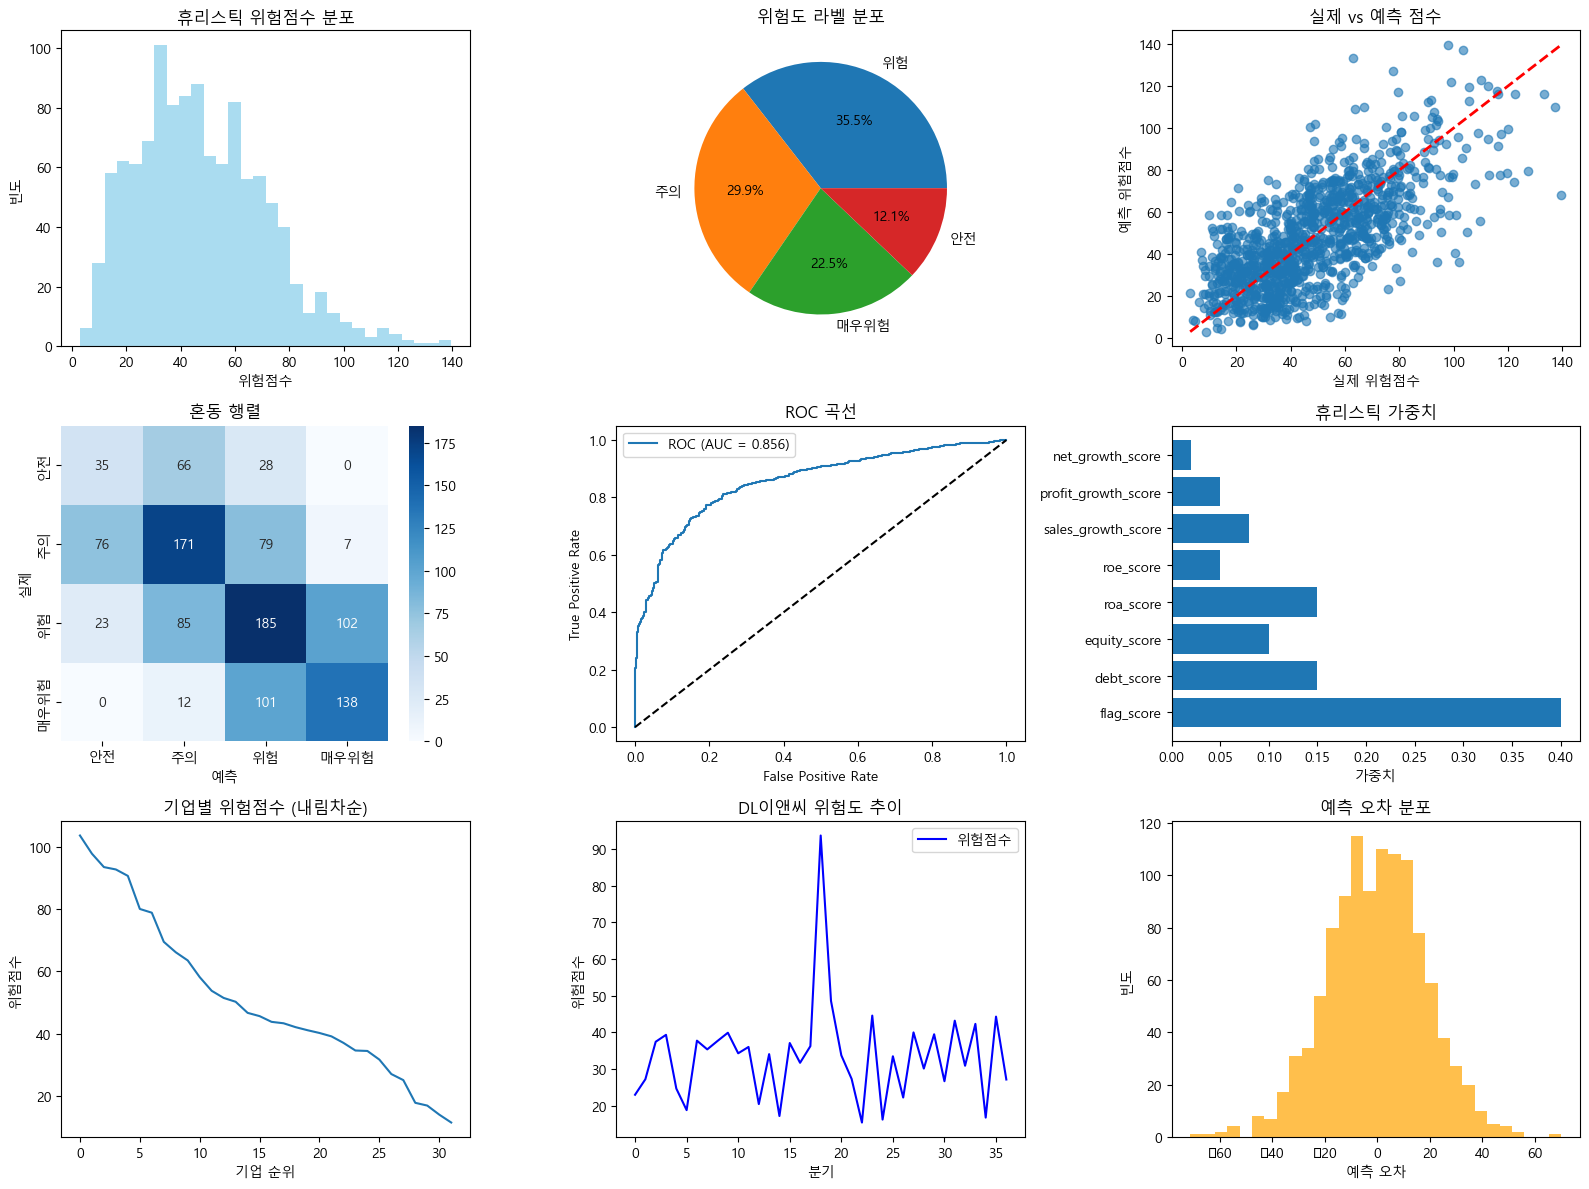

Task 8 완료



In [24]:
#%% ==================================================
# Task 8: 시각화
#%% ==================================================

print("=" * 50)
print("Task 8: 시각화")
print("=" * 50)

plt.figure(figsize=(16, 12))

# 1) 휴리스틱 점수 분포
plt.subplot(3, 3, 1)
plt.hist(df_sorted['heuristic_score'], bins=30, alpha=0.7, color='skyblue')
plt.title('휴리스틱 위험점수 분포')
plt.xlabel('위험점수')
plt.ylabel('빈도')

# 2) 라벨 분포
plt.subplot(3, 3, 2)
label_counts = df_sorted['heuristic_label_name'].value_counts()
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
plt.title('위험도 라벨 분포')

# 3) 실제 vs 예측 산점도
plt.subplot(3, 3, 3)
plt.scatter(y_true_score, y_score, alpha=0.6)
plt.plot([y_true_score.min(), y_true_score.max()], 
         [y_true_score.min(), y_true_score.max()], 'r--', lw=2)
plt.xlabel('실제 위험점수')
plt.ylabel('예측 위험점수')
plt.title('실제 vs 예측 점수')

# 4) 혼동 행렬 히트맵
plt.subplot(3, 3, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names.values(),
            yticklabels=label_names.values())
plt.title('혼동 행렬')
plt.xlabel('예측')
plt.ylabel('실제')

# 5) ROC 곡선
if len(np.unique(y_true_binary)) > 1:
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true_binary, y_score_binary)
    
    plt.subplot(3, 3, 5)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC 곡선')
    plt.legend()

# 6) 가중치 시각화
plt.subplot(3, 3, 6)
weights = list(heuristic_weights.values())
labels = list(heuristic_weights.keys())
plt.barh(range(len(labels)), weights)
plt.yticks(range(len(labels)), labels)
plt.title('휴리스틱 가중치')
plt.xlabel('가중치')

# 7) 기업별 최신 위험도
plt.subplot(3, 3, 7)
latest_scores = latest_data['heuristic_score'].sort_values(ascending=False)
plt.plot(range(len(latest_scores)), latest_scores)
plt.title('기업별 위험점수 (내림차순)')
plt.xlabel('기업 순위')
plt.ylabel('위험점수')

# 8) 시계열 추이
plt.subplot(3, 3, 8)
company_data = df_sorted[df_sorted['corp_name'] == sample_company]
plt.plot(company_data['heuristic_score'].values, 'b-', label='위험점수')
plt.title(f'{sample_company} 위험도 추이')
plt.xlabel('분기')
plt.ylabel('위험점수')
plt.legend()

# 9) 예측 오차 분포
plt.subplot(3, 3, 9)
errors = y_score - y_true_score
plt.hist(errors, bins=30, alpha=0.7, color='orange')
plt.title('예측 오차 분포')
plt.xlabel('예측 오차')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

print("Task 8 완료\n")

In [ ]:
#%% ==================================================
# Task 9: 결과 저장
#%% ==================================================

print("=" * 50)
print("Task 9: 결과 저장")
print("=" * 50)

# 결과 저장
result_df = df_sorted[[
    'corp_name', 'year', 'quarter',
    'predicted_risk_score', 'risk_score_100', 'predicted_risk_class', 'predicted_risk_name',
    'risk_label', 'risk_label_name', '위험점수'
] + feature_cols + risk_flags].copy()

result_df.to_csv('construction_linear_model_results.csv', index=False, encoding='utf-8-sig')

print(f"결과가 'construction_linear_model_results.csv'에 저장되었습니다.")
print(f"총 {len(result_df)}개 관측치 분석 완료")

# 최종 모델 요약
print(f"\n=== 최종 모델 요약 ===")
print(f"선형회귀 수식:")
print(f"{equation}")
print(f"선형회귀 R²: {r2:.3f}")
print(f"로지스틱회귀 정확도: {accuracy:.3f}")
print(f"학습 데이터 크기: {len(train_df)}")
print(f"예측 가능한 기업: {df_sorted['corp_name'].nunique()}개")

print("\nTask 9 완료: 모든 분석 완료!")
print("=" * 50)